# Генерация текста и его оценка

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
import os
import json
import re
import time

## Подходы к генерации текста
Для генерации воспользуемся стратегией семплирования и выберем в качестве сравниваемых параметров top_p + temperature. Есть интересная статья (ссылка ниже) для трактовки поведения языковых моделей при определенных сочетаниях этих параметров.


from https://community.openai.com/t/cheat-sheet-mastering-temperature-and-top-p-in-chatgpt-api-a-few-tips-and-tricks-on-controlling-the-creativity-deterministic-output-of-prompt-responses/172683

**Temperature** is a parameter that controls the “creativity” or randomness of the text generated. A higher temperature (e.g., 0.7) results in more diverse and creative output, while a lower temperature (e.g., 0.2) makes the output more deterministic and focused.In practice, temperature affects the probability distribution over the possible tokens at each step of the generation process. A temperature of 0 would make the model completely deterministic, always choosing the most likely token.


**Top_p** sampling is an alternative to temperature sampling. Instead of considering all possible tokens, model considers only a subset of tokens (the nucleus) whose cumulative probability mass adds up to a certain threshold (top_p).For example, if top_p is set to 0.1, the model will consider only the tokens that make up the top 10% of the probability mass for the next token. This allows for dynamic vocabulary selection based on context.

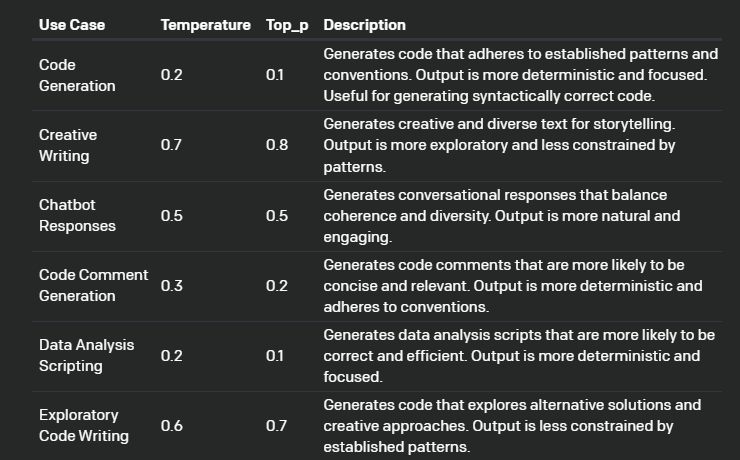

Создадим функцию для генерации, которая будет принимать модель, ее токенайзер, знак зодиака для генерация и оба параметра. Эту функцию будем использовать в другой функции при оценке генерируемых текстов.

In [2]:
# will use sampling strategy to generate every time new texts
# To use sampling generation strategy: in transformers, we set do_sample=True 
#       and deactivate Top-K sampling (more on this later) via top_k=0.

def generate_horo(model, tokenizer, zodiac, top_p, temperature):
        input_ids = tokenizer.encode(zodiac, return_tensors='pt')
        sample_output = model.generate(
            
            input_ids.to(device),
            do_sample=True,
            max_length=400,
            top_p=top_p,
            temperature = temperature,
            top_k = 0,
            no_repeat_ngram_size=2, 
            early_stopping = True
                )
        
        if model_name == 'T5':
            return tokenizer.decode(sample_output[0], skip_special_tokens=True)
        else:
            out = tokenizer.decode(sample_output[0][1:], skip_special_tokens=True)
            if '</s>' in out:
                out = out[:out.find('</s>')].strip()
            return out

## Подходы к оценке текста

Разные модели и стратегии генерации будем сравнивать и оценивать по 3-м характеристикам:

1. Языковая приемлимость (language acceptibilty) - корректность сформирвоанных моделью предложений с точки зрения орфографии, синтаксиса и т.д. Воспользуемся предобученной моделью https://huggingface.co/RussianNLP/ruRoBERTa-large-rucola, которая выдает лейбл = 1 для приемлимых с точки зрения языковых норм предложений. Будем считать % таких предложений в общем корпусе сгенерированных тестовых кейсов.
2. Разнообразие текстов (text diversity) - воспользуемся косинусной близостью, чтобы посмотреть похожесть текстов и возьмем разницу 1 - между средним коэффициентом для текста, что и будет характеристикой разнообразия. Для этих целей еще раз векторизуем тексты с помощью модели https://huggingface.co/sentence-transformers/LaBSE. Бдуем считать среднее разнообразие для выбранной моедли и стратегии.
3. Эмоциональная окрашенность текстов (text sentiment) - положительны или отрицательны тексты по своему содержанию. Для этого также воспользуемся готовой моделью, обученной для русского языка https://huggingface.co/seara/rubert-base-cased-russian-sentiment, которая выдает 3 лебла - neutral: нейтральный, positive: позитивный, negative: негативный. При оценке будем присваивать 0 только отрицательному лейблу, позитивный и нейтральный получат 1. Далее будем считать % НЕотрицательных текстов в сгенерированном корпусе.

Для всех метрик чем ближе значение к 100%, тем лучше.

Дополнительно будем выводить несколько текстов, чтобы оценить визуально общий результат.


In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline

grammar_tokenizer = AutoTokenizer.from_pretrained('RussianNLP/ruRoBERTa-large-rucola')
grammar_model = AutoModelForSequenceClassification.from_pretrained('RussianNLP/ruRoBERTa-large-rucola')
grammer_pipe = pipeline("text-classification", model=grammar_model, tokenizer = grammar_tokenizer)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [4]:
from sentence_transformers import SentenceTransformer
model_comparison = SentenceTransformer('sentence-transformers/LaBSE')

In [5]:
sent_pipe = pipeline("text-classification", model="seara/rubert-base-cased-russian-sentiment")

In [6]:
def review_gen(model, tokenizer, lst,  top_p, temperature):    
    gener_horos = pd.DataFrame()

    for zodiac in lst:
        
        start = time.time()
        gen_text = re.sub(re.compile('[^а-яА-ЯЁё !.,:?;«»]'), '',generate_horo(model = model, tokenizer = tokenizer, zodiac = zodiac, 
                      top_p = top_p, 
                      temperature = temperature
                      ))
        end = time.time()
        gen_time = round(end -start, 4)
        
        symbols = ['..', ',.', '?.', ' , ',' . ', ' : ', '.:', ':.', '«. »', '??', '?!', '.?', '? .', '? .']
        for symb in symbols:
            gen_text= gen_text.replace(symb, '')
        for symb in symbols:
            gen_text= gen_text.replace(symb, '')
            
        gram_accept = grammer_pipe(gen_text)[0]
        gram_label = gram_accept['label']

        if gram_label == 'LABEL_1':
            label = 1
        else:
            label = 0
            
        sent_review = sent_pipe(gen_text)[0]
        sent_label = sent_review['label']
        
        if sent_label == 'negative':
            s_label = 0
        else:
            s_label = 1


        new_row = {'zodiac': zodiac,
                   'gen_text': gen_text,
                   'grm_label': label,
                   'sentiment': s_label,
                   'gen_time': gen_time
                   }

        gener_horos = gener_horos.append(new_row, ignore_index = True)

    #display(gener_horos.iloc[5:8].style)
    sentences = gener_horos['gen_text'].tolist()
    embeddings = model_comparison.encode(sentences, normalize_embeddings=True)
    emb= sparse.csr_matrix(embeddings)
    sent_div = []
    for item in cosine_similarity(emb):
        sent_div.append(1-item.mean())
    gener_horos['diver'] = sent_div
    generation_result = {'model_name':model_name,
                        'params':f'temp={temperature},top_p={top_p}',
                        'gramm_corr_%': round(len(gener_horos[gener_horos['grm_label'] == 1])/len(gener_horos)*100,2),
                        'diversity': round(gener_horos['diver'].mean()*100, 2),
                        'positiv_%':round(len(gener_horos[gener_horos['sentiment'] == 1])/len(gener_horos)*100,2),
                        'avg_gen_time':round(gener_horos['gen_time'].mean(), 4)}
    print(generation_result)
    display(gener_horos.iloc[5:8].style)
    
    if os.path.exists('model_eval.json'):
        with open('model_eval.json',"r") as f:
            loaded = json.load(f)
        with open('model_eval.json',"w") as f:
            loaded.append(generation_result)
            json.dump(loaded, f)
    else:
         with open('model_eval.json',"w") as f:
                json.dump(eval_list, f)
                print('Eval result was not recorded!')

In [7]:
lst = ['Лев', 'Рыбы','Козерог','Телец', 'Скорпион', 'Близнецы', 'Овен', 'Весы', 'Стрелец', 'Рак', 'Водолей', 'Дева']

In [15]:
eval_list = []
with open('model_eval.json',"w") as f:
        json.dump(eval_list, f)

# 1. Модель ai-forever/ruT5-base

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = 'T5'
tokenizer_t5 = AutoTokenizer.from_pretrained("models/t5_new")
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("models/t5_new")

In [10]:
import torch
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
model_t5.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [16]:
#creative writing:
review_gen(model_t5, tokenizer_t5, lst*4,  top_p = 0.8, temperature = 0.7)

{'model_name': 'T5', 'params': 'temp=0.7,top_p=0.8', 'gramm_corr_%': 64.58, 'diversity': 40.91, 'positiv_%': 97.92, 'avg_gen_time': 0.5719}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Не стоит сегодня испытывать судьбу. Если вы не знаете, как ей поступить в той или иной ситуации, вам нужно позаботиться о своем здоровье. Не откладывайте на потом решение текущих проблем, не нужно думать, что все у вас получится, просто плывите по течению и не обращайте внимания на то, какие проблемы и трудности будут возникать в вашем доме.",0,1,0.503400,0.400313
6,Овен,"Если Вы думаете, что все в порядке, то сейчас самое время подумать о том, чтобы чтото изменить в своей жизни. Вы действительно можете изменить ситуацию в лучшую сторону, но не стоит слишком переживать. Если Вас попросят о помощи, не нужно уговаривать, если Вам придется заплатить за нее. Лучше скажите, как сильно Вы можете ее попросить, и все будет хорошо.",1,1,0.545700,0.465921
7,Весы,"Если Вы давно хотели поделиться своими мыслями с кемто из близких людей, то сегодня Вам будет нужно обсудить с ним какуюто очень важную тему, которая поможет Вам разрешить все беспокоящие Вас вопросы. Вы будете пребывать в очень заинтересованном и заинтересованном умонастроении и будете готовы поделиться с этим человеком своими переживаниями и переживаниям.",0,1,0.501900,0.429947


In [17]:
#exploratory code writing :
review_gen(model_t5, tokenizer_t5, lst*4,  top_p = 0.7, temperature = 0.6)

{'model_name': 'T5', 'params': 'temp=0.6,top_p=0.7', 'gramm_corr_%': 60.42, 'diversity': 37.93, 'positiv_%': 100.0, 'avg_gen_time': 0.5639}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Близнецам стоит учесть, что в эти сутки не все идет гладко. Не исключено, на вас будет возложена ответственность за свои слова, поступки, действия. Возможны трудности в дороге, в пути, при попытке добраться до нужного места. День не подходит для посещения врача, посещения стоматолога, поиска помощи, консультаций, работы с документами, заключения договора. Если вы в чемто сомневаетесь, лучше не искать в этом подвоха.",1,1,0.632700,0.391499
6,Овен,"Сегодня Овнам не стоит упускать шанс укрепить свои позиции, но не помешает быть более гибкими, если вы хотите добиться успеха в карьере, творчестве, профессиональной сфере. В эти сутки нежелательно заниматься рутиной, лучше уделить время выполнению рутинных обязанностей. Нежелательно откладывать важные дела, особенно, связанные с ремонтом, ремонтными работами, перестановками, обустройством жилья.",0,1,0.581000,0.341057
7,Весы,"Сегодня Весам не стоит отказываться от приглашения в гости, но не следует отказывать себе в этом удовольствии. Не стоит откладывать посещение официальных инстанций, официальных органов. Возможно, вам придется пройти собеседование, пройти тест на зрелость, на знание иностранного языка, в учебе или в контактах с иностранцами. В общении с близкими людьми постарайтесь быть более терпимыми и вежливыми.",0,1,0.594800,0.402272


In [18]:
#chat_bot :
review_gen(model_t5, tokenizer_t5, lst*4,  top_p = 0.5, temperature = 0.5)

{'model_name': 'T5', 'params': 'temp=0.5,top_p=0.5', 'gramm_corr_%': 72.92, 'diversity': 31.19, 'positiv_%': 100.0, 'avg_gen_time': 0.6044}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Сегодня Близнецам лучше не спешить с решением важных вопросов, а действовать по ситуации. Не стоит спешить, если вы не уверены в своих силах, не готовы к новым инициативам, готовы действовать в одиночку. В то же время, звезды советуют вам не поддаваться на провокации, иначе вы рискуете упустить из виду важные детали. Если вы чувствуете, что вас чтото не устраивает, лучше отложить визит к врачу, консультацию, визит в сервис.",1,1,0.634700,0.280313
6,Овен,"Сегодня Овнам лучше не заниматься решением финансовых вопросов, а сосредоточиться на решении текущих задач. Не стоит откладывать начинания, связанные с недвижимостью, наследством, налогами, долгами. Если вы не уверены в своих силах, лучше воздержаться от крупных покупок, от рискованных покупок и рискованного эксперимента. В общении с близкими людьми не стоит проявлять излишней эмоциональности, нежелательно проявлять агрессивность, проявлять неуважение к их мнению.",1,1,0.663600,0.300285
7,Весы,"Сегодня Весам не стоит отказываться от приглашения на вечеринку, свидание, вечеринки, пикника. Не стоит откладывать визит в гости, на свидание. Если вы не уверены в своих силах, лучше не отказывать себе в этом. В конце дня вам может понадобиться помощь от друзей, друзей или родственников. Возможно, вам придется отправиться в путешествие, отправиться на экскурсию, в поездку, посетить музей, музей.",0,1,0.559700,0.394979


In [19]:
#code comment generation :
review_gen(model_t5, tokenizer_t5, lst*4,  top_p = 0.2, temperature = 0.3)

{'model_name': 'T5', 'params': 'temp=0.3,top_p=0.2', 'gramm_corr_%': 62.5, 'diversity': 28.62, 'positiv_%': 100.0, 'avg_gen_time': 0.5903}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Сегодня Близнецам лучше не спешить с ответом на предложение, особенно, если оно касается работы, учебы, карьеры, бизнеса, профессиональной деятельности. Не стоит спешить, так как в этот день вы можете не заметить, как вас повлекут за собой другие люди. В конце дня не исключены неожиданные события, которые заставят вас пересмотреть свои планы, планы или планы.",1,1,0.521900,0.268699
6,Овен,"Сегодня Овнам стоит быть внимательнее к своему здоровью, особенно, если вы страдаете гипертонией. Не стоит увлекаться лекарственными препаратами, так как велика вероятность простудных заболеваний. Постарайтесь не перенапрягаться, иначе вы можете заработать хронические заболевания. В течение дня не исключены головные боли, но не стоит забывать о профилактике.",0,1,0.504200,0.316173
7,Весы,"Сегодня Весам не стоит рассчитывать на успех в делах, связанных с финансами, учебой, лечением, обучением. Не стоит откладывать начинания, связанные с недвижимостью, недвижимостьем, наследством или наследство. Важны не только материальные, но и моральные ценности, например, материальная база, семейный или семейные традиции. Если вы не уверены в своих силах, лучше не спешить с выводами.",0,1,0.648500,0.359189


# 2. Модель ai-forever/FRED-T5-large

In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = 'FRED_T5'
tokenizer_fred = AutoTokenizer.from_pretrained("models/fred_t5")
model_fred = AutoModelForSeq2SeqLM.from_pretrained("models/fred_t5")

In [9]:
import torch
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
model_fred.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(50364, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50364, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [11]:
#creative writing:
review_gen(model_fred, tokenizer_fred, lst*4,  top_p = 0.8, temperature = 0.7)

{'model_name': 'FRED_T5', 'params': 'temp=0.7,top_p=0.8', 'gramm_corr_%': 79.17, 'diversity': 33.0, 'positiv_%': 100.0, 'avg_gen_time': 2.7424}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"В этот день у Близнецов есть шанс достичь цели в сфере финансов или в области карьеры. Однако звезды советуют вам быть более осторожными, если вы не уверены в своих силах, а также в том, что вы делаете правильно. Не стоит верить на слово людям, которые не имеют ни малейшего представления о вашем потенциале. Вы можете стать жертвой мошенника, афериста, мошенницы. Возможны осложнения при пользовании техникой, при работе с документами. В делах сердечных следует остерегаться обмана и интриг. Рекомендуется отказаться от поездок. Можно провести день дома. Вечером не стоит заниматься рутиной. Полезно посетить салон красоты. Вечер подходит для романтического свидания. Для новых знакомств этот период неподходящий. Откажитесь от новых связей.",1,1,2.223500,0.307186
6,Овен,"В этот день вам будет легко общаться с людьми, особенно с теми, кто вам симпатичен. Это подходящий момент для начала любовного романа. В то же время вам не стоит слишком резко высказывать свое мнение, поскольку в итоге вы можете услышать в свой адрес критику. Не исключено, что вам придется пойти на компромисс с партнером, если он вам дорог. Вечер подходит для романтической встречи, встречи с друзьями. Возможно, вам стоит обсудить с ними какойто важный вопрос. Вечером хорошо провести время с детьми. У них может появиться интерес к вашей персоне. Возможны неожиданные подарки. Можно рассчитывать на помощь друзей. Вы можете получить неожиданное приглашение. Старайтесь не пренебрегать советами старших. Будьте готовы к непредвиденным переменам. Они не заставят себя долго ждать. .",1,1,2.265300,0.279735
7,Весы,"Весам стоит отказаться от лишней суеты, которая может создать вам проблемы. Не стоит тратить деньги на бесполезные вещи, а также на пустые обещания. Лучше отказаться и от покупки новых вещей, и даже от незначительных трат. Подходящий момент для учебы, для пополнения знаний, в том числе, связанных с иностранными языками, культурой и историей. Если вы не в курсе последних новостей, стоит обратиться за помощью к друзьям, коллегам или коллегам по работе. В личной жизни не стоит спешить с романтическими действиями. Прислушайтесь к мнению партнера. Возможно, он подскажет вам, как поступить правильно. В любовных отношениях не помешает осторожность. Вам не следует спешить. Сдержанность поможет сохранить равновесие?",1,1,2.240100,0.323427


In [12]:
#exploratory code writing :
review_gen(model_fred, tokenizer_fred, lst*4,  top_p = 0.7, temperature = 0.6)

{'model_name': 'FRED_T5', 'params': 'temp=0.6,top_p=0.7', 'gramm_corr_%': 89.58, 'diversity': 30.99, 'positiv_%': 97.92, 'avg_gen_time': 2.6764}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Близнецам не стоит игнорировать сигналы, которые посылает им организм. Если вы ощущаете недомогание, то это не повод отказываться от лечения. Не стоит откладывать визит к врачу, если вы чувствуете недомоганье, но не уверены в его причинах. В это время лучше отказаться от посещения косметолога, стоматолога. Возможно, вам придется посетить кабинет эндокринолога или пройти обследование у специалиста в области эндоскопии. Во избежание проблем с пищеварением, постарайтесь употреблять в пищу больше витаминов. Вечером хорошо прогуляться на свежем воздухе. Хорошо принимать ванну. Можно заняться йогой. Рекомендуется массаж. « ». «» » » « » «.».». « » «» .» « и. в.",1,1,2.534200,0.385410
6,Овен,"В этот день Овнам стоит обратить внимание на свои финансы, а также на состояние здоровья. Не стоит откладывать на потом важные дела, в том числе, связанные с лечением и профилактикой заболеваний. В конце дня возрастет вероятность непредвиденных расходов, связанных с поездками, покупками. Возможны неожиданные траты на подарки, развлечения, на развлечения детей. Возможно, вы решите приобрести новый гаджет или компьютер. Вечером не стоит делать крупные покупки. Желательно не увлекаться алкоголем. Лучше не планировать на вечер романтическое свидание. Ближе к ночи лучше не заниматься делами. Вечер подходит для отдыха. Хорошо провести его с детьми. Можно заняться творчеством. Есть шанс получить удовольствие от общения с друзьями. День подходит и для романтического свидания. Стоит избегать излишеств. Вечер благоприятен для общения. Хорошее время для прогулок. Рекомендуется посетить врача. Уделите внимание детям. Вы можете получить подарок. Это прекрасный день для свидания!. Вечер лучше провести в кругу семьи. Хороший день Вечером хорошо заняться спортом. Будет возможность хорошо отдохнуть. Принимайте гостей. Приятного вечера! и. Хорошего вечера.,, и Приятных снов! и др. приятного вечера и приятного!дня! и приятных снов. И др. и пр.!? :! :!!.!!.!!. И. и!! » День благоприятный Будьте внимательны к своему здоровью. Берегите себя. Будьте осторожны. Отдыхайте. Больше двигайтесь. Помните о том, что сон лучшее лекарство. Он не только укрепляет нервы. Но и помогает справиться с проблемами. Особенно, если они есть. Делайте все правильно. Вот увидите, все будет хорошо. А это главное. Главное не переутомляться. Здоров",0,1,5.662400,0.292253
7,Весы,"Сегодня Вы будете пребывать в очень эмоциональном и впечатлительном умонастроении, и Вам будет очень трудно сохранять хладнокровие и хладнокровность в общении с окружающими Вас людьми. Поэтому старайтесь не вступать с ними в пререкания и не высказывать им свое недовольство их поведением. Лучше просто улыбайтесь и будьте уверены в том, что они Вас не обидят. В конце концов, они же не виноваты, в чем проблема? Они просто не понимают, как Вы можете быть таким раздражительным. Вы должны научиться сдерживать свои эмоции. Это поможет Вам сохранить душевное равновесие. А это очень важно. Не забывайте об этом. « ». ».».",1,1,2.303600,0.369295


In [13]:
#chat_bot :
review_gen(model_fred, tokenizer_fred, lst*4,  top_p = 0.5, temperature = 0.5)

{'model_name': 'FRED_T5', 'params': 'temp=0.5,top_p=0.5', 'gramm_corr_%': 85.42, 'diversity': 23.81, 'positiv_%': 100.0, 'avg_gen_time': 2.3731}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Сегодня Близнецам стоит быть внимательнее к деталям, особенно, если речь идет о работе, учебе, контактах, лечении, получении информации. Не стоит полагаться на случай, полагаться только на свои силы, на интуицию. В это время не стоит доверять чужим словам, доверять обещаниям, верить обещанию, данному в последний момент. Возможны ошибки в расчетах, в документах, при оформлении документов. Стоит быть осторожнее в поездках, поездкам с детьми. Может подвести зрение. Лучше не заниматься вопросами недвижимости, недвижимости и недвижимости.",1,1,1.861700,0.258845
6,Овен,"Сегодня Овнам стоит быть более внимательными к мелочам, особенно, если они касаются домашних дел, работы, финансов, здоровья. Не стоит игнорировать мелочи, связанные с питанием, бытом, здоровьем, питательными веществами, техникой, лекарствами, средствами связи. В эти сутки не стоит полагаться на случай, полагаться только на свои силы и знания. Если вы не уверены в своих силах, лучше не рисковать. Лучше не брать на себя ответственность, не заниматься рутинными делами. Стоит избегать излишней эмоциональности. Возможны проблемы с самочувствием. Вечером лучше отдохнуть. Возможно, вам придется заняться домашними делами, детьми. Хорошо заняться косметическим ремонтом. Можно посетить врача. Вечер подходит для отдыха. Желательно не принимать важных решений. Рекомендуется отдых в кругу семьи. Полезно посетить баню. ? :",1,1,2.574500,0.223393
7,Весы,"Сегодня Весам не стоит планировать на этот день важные дела. В течение дня вы можете столкнуться с препятствиями, которые не позволят вам добиться желаемого. Не стоит рассчитывать на помощь друзей, на поддержку начальства, официальных инстанций. Возможны проблемы с транспортом, транспортом общего пользования, связью. Возможно, вам придется отменить поездку, отменить встречу, перенести визит. Лучше не планировать важные мероприятия, не заниматься вопросами, связанными с недвижимостью, здоровьем, наследством. Вечером лучше не отправляться в путь. Можно отдохнуть, заняться любимым хобби. Вечер подходит для романтического свидания. Хорошо провести время с детьми. Есть шанс получить подарок. Удачный день для посещения врача. Стоит избегать травм. День подходит не только для отдыха. Важно правильно питаться. Полезно следить за состоянием печени. Улучшается состояние кожи. Хороший день, чтобы заняться спортом. Благоприятны косметические процедуры. Рекомендуется массаж. Прекрасный день. Гороскоп и таропрогноз на июль. ? : ,!?,,! !. Это не тот день! Это просто день такой! !.!!.!!!!!! :! .!!?:!!!;!:!.!;!.;;!»!»!»;!».!».!»;.».»»?»;»»!».».!».».!»».».» ». «»».",1,1,5.824700,0.261722


In [14]:
#code comment generation :
review_gen(model_fred, tokenizer_fred, lst*4,  top_p = 0.2, temperature = 0.3)

{'model_name': 'FRED_T5', 'params': 'temp=0.3,top_p=0.2', 'gramm_corr_%': 97.92, 'diversity': 23.03, 'positiv_%': 100.0, 'avg_gen_time': 2.076}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Сегодня Близнецам не стоит полагаться на удачу, лучше не полагаться и на свои силы. Не стоит рассчитывать на помощь друзей, на поддержку начальства, официальных инстанций. В это время не исключены проблемы с техникой, техникой безопасности, с документами, документами на недвижимость, а также с законом, в том числе, о наследстве. Возможны проблемы в дороге, при попытке связаться с кемлибо. Лучше не планировать на этот день важные встречи, важные переговоры. Вечером лучше отдохнуть, расслабиться. Можно заняться спортом. Хорошо провести время с детьми. Возможно, вы получите неожиданное приглашение. Это подходящий момент для романтического свидания. Вечер подходит для отдыха. Если вы не в настроении, можно посетить ресторан. Желательно избегать алкоголя.",1,1,2.249700,0.211040
6,Овен,"Сегодня Овнам не стоит бояться перемен. Если вы не уверены в своих силах, не бойтесь попросить помощи у друзей, родственников, единомышленников. Не стоит отказываться от помощи, если она вам необходима. В это время вы можете получить неожиданное известие, получить известие издалека. Возможно, вы получите приглашение на свидание, на вечеринку, в гости. Возможны приятные новости от друзей. Можно рассчитывать на помощь от родителей, друзей по несчастью. Хорошо заниматься благотворительностью. Вечером стоит заняться делами, связанными с домом, семьей. Это подходящее время для посещения врача. Может потребоваться помощь в лечении. Вечер подходит для романтического свидания. Лучше не планировать на этот день важные встречи.",1,1,2.240500,0.217354
7,Весы,"Сегодня Весам не стоит рассчитывать на полную свободу действий. Не стоит полагаться на случай, на удачу, а также на помощь друзей и близких. В эти сутки не исключены проблемы с техникой, техникой безопасности, с документами, документами на недвижимость, счетами, платежными документами. Возможны проблемы в дороге, в связи с поломкой транспорта, сбоем в работе оборудования. Стоит быть внимательнее при пользовании электроприборами, компьютерной техникой. Возможно, придется столкнуться с проблемами в сфере финансов. Лучше не планировать на этот день важные мероприятия. Вечером не помешает расслабиться. Можно принять ванну, расслабиться в кругу семьи. Хорошо провести время с детьми. Вечер подходит для романтического свидания.",1,1,2.169800,0.247605


# 3. Модель google/mt5-large

In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = 'mt5'
tokenizer_mt = AutoTokenizer.from_pretrained("models/mt5")
model_mt = AutoModelForSeq2SeqLM.from_pretrained("models/mt5")

In [9]:
import torch
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
model_mt.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 1024)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 1024)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=Fals

In [11]:
#creative writing:
review_gen(model_mt, tokenizer_mt, lst*4,  top_p = 0.8, temperature = 0.7)

{'model_name': 'mt5', 'params': 'temp=0.7,top_p=0.8', 'gramm_corr_%': 37.5, 'diversity': 40.2, 'positiv_%': 97.92, 'avg_gen_time': 1.979}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Сегодня Вы будете чувствовать себя очень уверенно и спокойно. Вы прекрасно знаете, что если сегодня ктото из Ваших друзей предложит Вам какуюто роскошную услугу, то этот человек может Вами воспользоваться. Однако не стоит делать это для того,чтобы оказать комуто услугой. Если Вы не хотите дать ему шанс, просто дайте этому человеку понять, как Вы должны поступить.",1,1,1.873200,0.424076
6,Овен,"Сегодня Вы будете склонны игнорировать свои эмоции, поэтому не стоит беспокоиться о том, что может произойти чтото плохое. Если Вы не уверены в том точном исходе происходящего, лучше дайте себе время на то,чтобы успокоиться. У Вас достаточно сил для того, как сделать все возможное, но если Вы хотите, то можете смело принимать участие в происшествиях.",0,1,1.932500,0.353066
7,Весы,"Сегодня Весам лучше отказаться от инициативы в делах, связанных с личными и профессиональными проблемами. Не стоит принимать важные решения, особенно если вы заняты домашними делами, имеете дело с бытом или имуществом, занимаетесь техническим, медицинским, хозяйственным делом. Если вы склонны к сомнительным сделкам, вам стоило бы оказать помощь друзьям, партнерам, начальству.",1,1,1.722600,0.382374


In [12]:
#exploratory code writing :
review_gen(model_mt, tokenizer_mt, lst*4,  top_p = 0.7, temperature = 0.6)

{'model_name': 'mt5', 'params': 'temp=0.6,top_p=0.7', 'gramm_corr_%': 50.0, 'diversity': 34.68, 'positiv_%': 97.92, 'avg_gen_time': 2.2107}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Сегодня Близнецам лучше отказаться от общения с людьми, которые испытывают некоторые проблемы. Если вы не уверены в своих силах, то можно попытаться наладить отношения с теми, с кем вы давно не виделись. Не стоит игнорировать нюансы, связанные с финансами, недвижимостью, бизнесом, финансовыми вопросами. Важно правильно расставить приоритеты, избегать лишних расходов.",1,1,2.078400,0.339385
6,Овен,"Сегодня Вы будете особенно эмоциональны и восприимчивы к тому, что происходит в Вашей жизни. Если Вы чувствуете, будто уже давно не виделись в новом месте, то сегодня Вам лучше не делать ничего. Вы можете ощутить, как сильно устали от того, когда начнете вести себя не так, но если Вы этого не сделаете, не стоит беспокоиться о том, чем Вы занимаетесь.",0,1,2.256600,0.365332
7,Весы,"Сегодня Вы будете пребывать в довольно подавленном и нерешительном умонастроении, однако, к сожалению, это не означает, что Вы не сможете справиться с этой задачей. Просто Вам хочется сделать все возможное, прежде чем принимать окончательное решение. К счастью, Ваша уверенность в себе поможет Вами справляться с любыми трудностями самостоятельно.",0,0,1.883400,0.393673


In [13]:
#chat_bot :
review_gen(model_mt, tokenizer_mt, lst*4,  top_p = 0.5, temperature = 0.5)

{'model_name': 'mt5', 'params': 'temp=0.5,top_p=0.5', 'gramm_corr_%': 37.5, 'diversity': 27.35, 'positiv_%': 100.0, 'avg_gen_time': 2.3113}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Сегодня Близнецам лучше не спешить с выводами, а тщательнее продумывать каждый свой шаг. Если вы уверены в своих силах, то можно спокойно и без лишних усилий взяться за решение текущих задач. Важно не откладывать важные дела, не поддаваться на провокации, в том числе, на грубые провокационные выпады. Не стоит принимать решения, связанные с работой, здоровьем, семьей, работниками техники, транспорта.",0,1,2.365000,0.224465
6,Овен,"Сегодня Овнам лучше не спешить с выводами, а тщательнее продумывать каждый свой шаг. Если вы уверены в своих силах, то сегодня можно спокойно и эффективно работать. Не стоит игнорировать текущие нюансы, не стоить принимать важные решения, в том числе, касающиеся финансов, здоровья, финансовых вопросов. Важно не перенапрягаться, избегать стрессовых ситуаций, нервозности, раздражительности.",0,1,2.461800,0.218106
7,Весы,"Сегодня Весам лучше не спешить с выводами, а дать себе время на то, чтобы их обдумать. Если вы уверены в своих силах, то сегодня можно спокойно и приятно провести время. Вечер может оказаться для вас удачным, но не стоит делать ставку на случайные нюансы, в том числе, на личные тайны. Не стоить принимать важные решения, не поддаваться иллюзиям, откладывать дела, связанные с работой, здоровьем, учебой.",0,1,2.664000,0.222210


In [14]:
#code comment generation :
review_gen(model_mt, tokenizer_mt, lst*4,  top_p = 0.2, temperature = 0.3)

{'model_name': 'mt5', 'params': 'temp=0.3,top_p=0.2', 'gramm_corr_%': 45.83, 'diversity': 15.83, 'positiv_%': 100.0, 'avg_gen_time': 2.3335}


,zodiac,gen_text,grm_label,sentiment,gen_time,diver
5,Близнецы,"Сегодня Близнецам лучше не спешить с выводами, а тщательнее продумывать каждый свой шаг. Если вы уверены в своих силах, то можно спокойно и эффективно выполнять свои обязанности, не откладывая на потом решение текущих задач. Важно не перенапрягаться, избегать стрессовых ситуаций, в том числе, с помощью физической силы. Не стоит делать покупки, покупать косметику, украшения, инструменты, лекарства.",1,1,2.326800,0.135128
6,Овен,"Сегодня Овнам лучше не спешить с выводами, а тщательнее следить за своим самочувствием. Если вы плохо себя чувствуете, то сегодня можно спокойно заниматься своими делами, не стоит делать лишних трат. Важно не перенапрягаться, избегать переутомления, перенапряжения, нервозности, раздражительности. Не стоить принимать важные решения, в том числе, касающиеся здоровья.",1,1,2.003900,0.144011
7,Весы,"Сегодня Весам лучше не спешить с выводами, а тщательнее продумывать каждый свой шаг. Если вы уверены в своих силах, то можно спокойно и эффективно выполнять свои обязанности, не откладывая на потом решение текущих задач. Важно не перегружать себя новыми делами, в том числе, финансовыми. Не стоит игнорировать нюансы, связанные с финансами например, с наследством, наследованием, налогами.",0,1,2.328000,0.156745


# Сравнение результатов генерации

In [21]:
with open('model_eval.json',"r") as f:
    loaded = json.load(f)
res = pd.DataFrame(loaded)
res

,model_name,params,gramm_corr_%,diversity,positiv_%,avg_gen_time
0,T5,"temp=0.7,top_p=0.8",64.58,40.91,97.92,0.5719
1,T5,"temp=0.6,top_p=0.7",60.42,37.93,100.00,0.5639
2,T5,"temp=0.5,top_p=0.5",72.92,31.19,100.00,0.6044
3,T5,"temp=0.3,top_p=0.2",62.50,28.62,100.00,0.5903
4,FRED_T5,"temp=0.7,top_p=0.8",79.17,33.00,100.00,2.7424
5,FRED_T5,"temp=0.6,top_p=0.7",89.58,30.99,97.92,2.6764
6,FRED_T5,"temp=0.5,top_p=0.5",85.42,23.81,100.00,2.3731
7,FRED_T5,"temp=0.3,top_p=0.2",97.92,23.03,100.00,2.0760
8,mt5,"temp=0.7,top_p=0.8",37.50,40.20,97.92,1.9790
9,mt5,"temp=0.6,top_p=0.7",50.00,34.68,97.92,2.2107


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

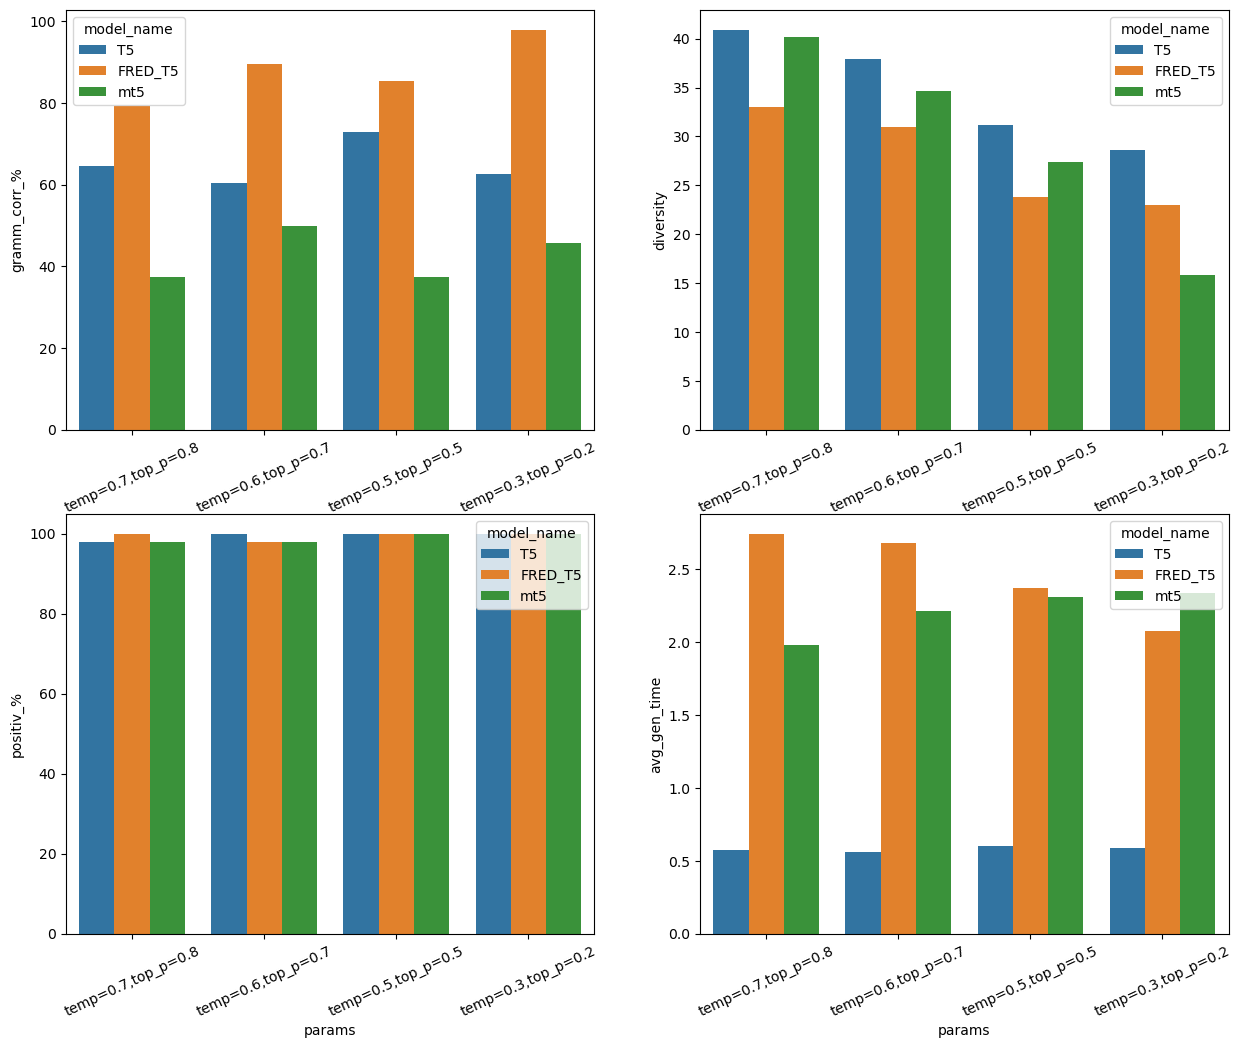

In [40]:
to_plot = ['gramm_corr_%', 'diversity', 'positiv_%', 'avg_gen_time']
fig = plt.figure(figsize = (15,12))
plt.tight_layout()

for i, feature in enumerate(to_plot):
    plt.subplot(2,2,i+1)
    sns.barplot(x='params', y = feature, data=res,  hue = 'model_name')
    plt.xticks(rotation = 25)